AiAp - Mini project 1
# Lego CNN
Simon Hager
Kevin Löffler

In [51]:
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Step 1
## Import Data
Our dataset consists of 3D modeled lego bricks that are rendered as 400x400 greyscale png images. There are 50 different bricks and each brick is rendered in 800 angels giving us a total of 40'000 images. According to the project specification we reduced the dataset to 20 classes (bricks) resulting in 16'000 images.

[Data source](https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images)

### Classes (Original Data)
1. Brick Corner 1x2x2
2. Plate Corner 2x2
3. Peg with friction
4. Brick 2x4
5. Brick 2x3
6. Brick 2x2
7. Brick 1x2
8. Brick 1x1
9. Brick 1x4
10. Plate 2x4
11. Plate 2x3
12. Plate 2x2
13. Plate 1x2
14. Plate 1x1
15. Roof Tile 1x4
16. Roof Tile 2x3
17. Roof Tile 2x2
18. Roof Tile 1x2
19. Roof Tile Corner 2x2
20. Roof Corner Inside Tile 2x2
21. Round Brick 1x1
22. Curved Brick 2 Knobs
23. Flat Tile 2x2
24. Flat Tile 1x2
25. Flat Tile 1x1
26. Roof Tile 2x3
27. Brick 1x3
28. Plate 1x3
29. Brick Bow 1x4
30. Roof Tile Outside 3x3
31. Technic Brick 1x2
32. Plate 1x2 with Knob
33. Flat Tile Round 2x2
34. Connector Peg
35. Roof Tile 1x3
36. Brick Bow 1x3
37. Brick D16 Cross
38. Lever 3M
39. Flat Tile Corner 2x2
40. Roof Tile 1x2
41. Beam 1M
42. Flat Tile Round 2x2
43. Plate 2 Knobs 2x2
44. Lever 2M
45. Cross Blocks 2x2
46. Bush 2M Friction Cross Axle
47. Beam 1x2
48. Roof Tile 1x1
49. Roof Tile 1x2
50. Roof Tile Inside 3x3

### Classes
1. Brick Corner
2. Plate Corner
3. Peg
4. Brick 2x4
5. Brick 2x3
6. Brick 2x2
7. Brick 1x2
8. Brick 1x1
9. Brick 1x4
10. Plate 2x4
11. Plate 2x3
12. Plate 2x2
13. Plate 1x2
14. Plate 1x1
15. Roof 2x4
16. Roof 2x3
17. Roof 2x2
18. Roof 2x1
19. Roof Corner 2x2
20. Flat 1x1


In [52]:
bricks = ['001 Corner', '002 Peg', '003 Brick', '004 Plate', '005 Roof']
# ['001 Brick Corner', '002 Plate Corner', '003 Peg', '004 Brick 2x4', '005 Brick 2x3', '006 Brick_2x2', '007 Brick 1x2', '008 Brick 1x1', '009 Brick 1x4', '010 Plate 2x4', '011 Plate 2x3', '012 Plate 2x2', '013 Plate 1x2', '014 Plate 1x1', '015 Roof 2x4', '016 Roof 2x3', '017 Roof 2x2', '018 Roof 2x1', '019 Roof Corner 2x2', '020 Flat 1x1']

In [53]:
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    'lego-bricks/dataset-v3',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = 32,
    image_size = (400, 400),
    shuffle = True,
    seed = 7,
    validation_split = 0.2,
    subset = 'training'
)

Found 2000 files belonging to 5 classes.
Using 1600 files for training.


In [54]:
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'lego-bricks/dataset-v3',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = 32,
    image_size = (400, 400),
    shuffle = True,
    seed = 7,
    validation_split = 0.2,
    subset = 'validation'
)

Found 2000 files belonging to 5 classes.
Using 400 files for validation.


In [55]:
testing_data.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=13>

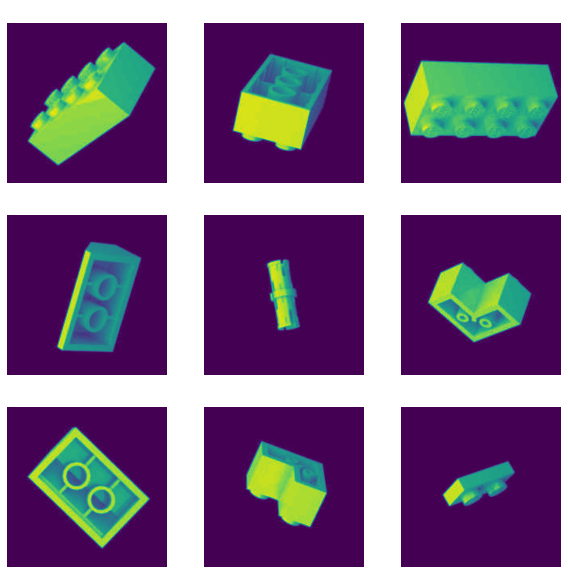

In [56]:
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(bricks[labels[i]], color='white')
        plt.axis('off')
        # plt.colorbar()

Step 2
## Build the Model

[Caching](https://www.tensorflow.org/guide/data_performance#caching) save some operations (like file opening and data reading) from being executed during each epoch. It caches the dataset in first epoch in memory or on local storage for further epochs.
With [Prefetching](https://www.tensorflow.org/guide/data_performance#prefetching), the input pipeline is reading the data for step `s+1` while the model is executing training step `s`. A side effect is the reduced memory usage.

In [57]:
AUTOTUNE = tf.data.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size = AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size = AUTOTUNE)

In [58]:
# normalization_layer = layers.Rescaling(1./255)

The first layer is only for reformation and normalization of the dataset. Rescaling format the input to a lower space. In this szenario, it reduces the image color range from rgb (0-255) to a simple black and white schema (0-1). That is required because the model can't handle the original input efficient.

Conv2D is a convolution layer. It takes xxx. Here we use a total of 16 filters with a kernel size of 3x3 and then we use `MaxPooling2D` to reduce the spatial dimension of the output.

Dense layer can only process vectors as input. Therefore `Flatten` layer is predestined to preprocess the data into this format.

In [59]:
model = tf.keras.models.Sequential([
    layers.Rescaling(1./255, input_shape = (400, 400, 1)),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    # layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    # layers.MaxPooling2D(),
    # layers.Dropout(0.2),  # doesn't seam to change much
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(len(bricks))
])

In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 400, 400, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 400, 400, 16)      160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 200, 200, 16)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 640000)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               81920128  
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                      

In [61]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [62]:
model.compile(optimizer = optimizer,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy', 'categorical_accuracy'])

Step 3
## Train the Model

In [63]:
epochs = 5

In [64]:
history = model.fit(
    training_data,
    validation_data = testing_data,
    epochs = epochs
)

Epoch 1/5
49/50 [============================>.] - ETA: 0s - loss: 1.1424 - accuracy: 0.7736 - categorical_accuracy: 0.2232

KeyboardInterrupt: 

Visualize training results:

In [ ]:
training_accuracy = history.history['accuracy']
training_val_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
training_val_loss = history.history['val_loss']

epochs_range = range(epochs)

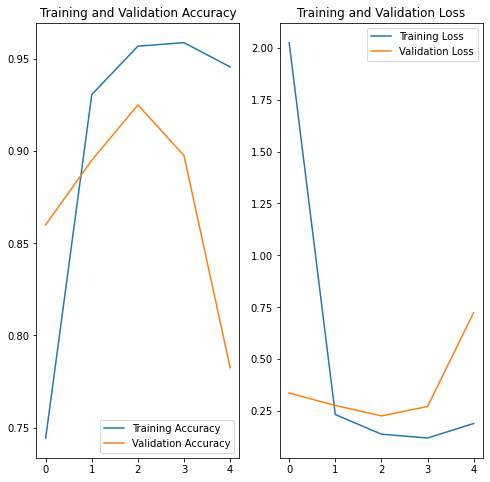

In [109]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, training_val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label = 'Training Loss')
plt.plot(epochs_range, training_val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.show()

With the following confusion matrices, we can evaluate, how well the model performs on random data

In [120]:

y_pred = []  # store the predicted labels
y_true = []  # store the true labels

# iterate over the dataset
# x = image
# y = label
for x, y in testing_data:
    y_true.append(y)
    predictions = model.predict(x)
    y_pred.append(tf.argmax(predictions, axis=-1)) # 1 or -1

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

true_positives = [0] * len(bricks)
false_positives = [0] * len(bricks)
true_negatives = [0] * len(bricks)
false_negatives = [0] * len(bricks)
relations = [[0] * len(bricks)] * len(bricks)

for x, y in zip(correct_labels, predicted_labels):
    relations[y][x] += 1
    if tf.math.equal(tf.cast(x, tf.int64), y):
        true_positives[x]+=1
        for z in false_positives:
            if not z == x:
                true_negatives[x]+=1
    else:
        false_positives[x]+=1
        false_negatives[y]+=1


tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int64) [1, 0, 0, 0, 0] [[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0]]
tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int64) [2, 0, 0, 0, 0] [[2, 0, 0, 0, 0], [2, 0, 0, 0, 0], [2, 0, 0, 0, 0], [2, 0, 0, 0, 0], [2, 0, 0, 0, 0]]
tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int64) [3, 0, 0, 0, 0] [[3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0]]
tf.Tensor(4, shape=(), dtype=int32) tf.Tensor(2, shape=(), dtype=int64) [3, 0, 0, 0, 1] [[3, 0, 0, 0, 1], [3, 0, 0, 0, 1], [3, 0, 0, 0, 1], [3, 0, 0, 0, 1], [3, 0, 0, 0, 1]]
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(1, shape=(), dtype=int64) [3, 1, 0, 0, 1] [[3, 1, 0, 0, 1], [3, 1, 0, 0, 1], [3, 1, 0, 0, 1], [3, 1, 0, 0, 1], [3, 1, 0, 0, 1]]
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(1, shape=(), dtype=int64) [3, 2, 0, 0, 1] [[3, 2, 0, 0, 1], [3, 2, 0, 0, 1], [3, 2, 

It seems like label '005 Roof' is chosen way too often. Namely, even when other labels are supposed to be recognized. The next step was to investigate which labels are predominantly used with the wrong label '005 Roof' and to analyze to what extent the labels are similar.

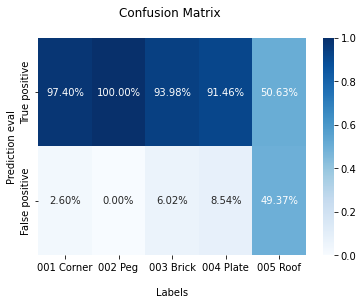

In [111]:
total_pos = np.sum(list(map(list, zip(true_positives, false_positives))), axis=1)

ax = sns.heatmap([true_positives/total_pos, false_positives/total_pos], annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix \n')
ax.set_xlabel('\nLabels')
ax.set_ylabel('Prediction eval')

ax.xaxis.set_ticklabels(bricks)
ax.yaxis.set_ticklabels(['True positive','False positive'])

plt.show()


[253, 305, 332, 348, 192]
[6, 7, 37, 0, 3]


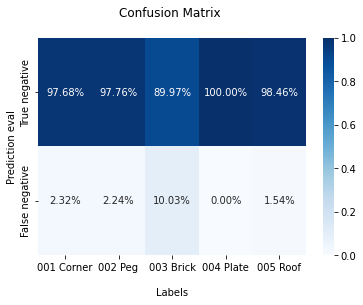

In [96]:
total_neg = np.sum(list(map(list, zip(true_negatives, false_negatives))), axis=1)

ax = sns.heatmap([true_negatives/total_neg, false_negatives/total_neg], annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix \n')
ax.set_xlabel('\nLabels')
ax.set_ylabel('Prediction eval\n')

ax.xaxis.set_ticklabels(bricks)
ax.yaxis.set_ticklabels(['True negative','False negative'])

plt.show()

Finally, the last confusion matrix summarizes the predictions in true or false results. It categorizes the True Negative, False Positive, False Negative and True Positive mappings.

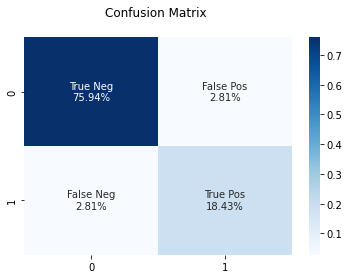

In [108]:
total_neg = np.sum(list(map(list, zip(true_negatives, false_negatives))), axis=1)

true_negatives_total = np.sum(true_negatives)
false_positives_total = np.sum(false_positives)
false_negatives_total = np.sum(false_negatives)
true_positives_total = np.sum(true_positives)

total = np.sum([true_negatives_total, false_positives_total, false_negatives_total, true_positives_total])

cf_matrix = np.array([[true_negatives_total/total, false_positives_total/total], [false_negatives_total/total, true_positives_total/total]])

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flat]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix \n')

plt.show()
